In [1]:
#### Create Plots based on OSCAR xml files ####


# used python version 3.10.6

In [86]:
# import libraries

import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
import os
import pandas as pd
import datetime as dt

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.lines as mlines
from IPython import display 
import matplotlib.animation as animation
import datetime

In [43]:
# import functions defined in functions.py

from functions import * 

In [44]:
# define function: save basic information to json file

def save_basic_info_to_json(country):

    """create json file with information on WIGOS ID, Name, latitude, longitude, elevation, facility Type, observed Properties, 
       date Established, date Closed & reportingStatus of all stations within selected country

    Parameters:
        country (str): country code - e.g. "KEN" for Kenya
    """    

    # create empty json file to add station data from xml files to 
    j_data = '{"stations":[]}' 
    file = open("stations.json", "w")
    file.write(j_data)
    file.close()

    # get list of WIGOS identifiers of country of interest
    wigosIds = get_WIGOS_ID_country(country)

    # Get station xml Files via jOAI and save relevant information in json file
    for id in wigosIds:

        # get url
        url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id

        # get xml from url
        document = requests.get(url)
        soup= BeautifulSoup(document.content,"xml")

        # get information from OAI 
        metadata = soup.find('metadata') #check if xml file is available on jOAI
        if metadata:

            # Name
            name = soup.find("name")
            name = name.get_text()

            # Location
            location = soup.find_all('pos')
            location = re.findall(r'.*?\>(.*)\<.*',str(location))[0]
            loc = re.findall(r'-?[0-9]*\.?[0-9]*', location) 
            lat = loc[0]
            lon = loc[2]
            if len((loc)) == 6: # check if elevation is given
                ele = loc[4]
            else:
                ele = "unknown"

            # facility type
            facilityType = soup.find('facilityType')
            facilityType = re.findall(r'http://codes.wmo.int/wmdr/FacilityType/(.*)\"\s.*',str(facilityType))[0]
        
            # observed Variables
            observedProperties = soup.find_all('observedProperty')
            observedProperties_notation = re.findall(r'\d+',str(observedProperties))
                
            # Date established
            dateEstablished = soup.find_all('dateEstablished')
            if dateEstablished:
                dateEstablished = re.findall(r'\d{4}-\d{2}-\d{2}',str(dateEstablished))[0]
            else: 
                dateEstablished = "unknown"

            # Date closed
            dateClosed = soup.find_all('dateClosed')
            if dateClosed:
                dateClosed = re.findall(r'\d{4}-\d{2}-\d{2}',str(dateClosed))[0]
            else: 
                dateClosed = "NA"

            # ReportingStatus
            reportingStatus = soup.find('reportingStatus')
            if reportingStatus:
                reportingStatus = soup.find_all('reportingStatus')
                reportingStatus = re.findall(r'http://codes.wmo.int/wmdr/ReportingStatus/(.*)\"\s.*',str(reportingStatus))[0]
            else:
                reportingStatus = "unknown"
            
            # save information to json File 
            aDict = {"wigosId" : id, "name":name, "lat":lat, "lon":lon, "ele":ele, "facilityType":facilityType, "observedProperties" : observedProperties_notation, "dateEstablished" : dateEstablished, "dateClosed" : dateClosed, "reportingStatus" : reportingStatus}
            print(aDict)
            write_json(aDict)
   

In [111]:
save_basic_info_to_json(country="KEN")
json_file = os.getcwd()+'/stations.json'

{'wigosId': '0-404-300-301570787AS00074', 'name': 'AIC Churo Girls  High School', 'lat': '0.7668', 'lon': '36.4056', 'ele': '1798.0', 'facilityType': 'landFixed', 'observedProperties': ['251', '210', '216', '224', '12005', '12006'], 'dateEstablished': '2021-11-29', 'dateClosed': 'NA', 'reportingStatus': 'operational'}
{'wigosId': '0-404-300-402261127AS63663', 'name': 'ALUPE', 'lat': '0.497', 'lon': '34.1252', 'ele': 'unknown', 'facilityType': 'landFixed', 'observedProperties': ['251', '210', '210', '216', '224', '225', '230', '12005', '12006'], 'dateEstablished': '2020-09-22', 'dateClosed': 'NA', 'reportingStatus': 'operational'}
{'wigosId': '0-404-300-271440721AS00049', 'name': 'Ainabkoi KCC Plant', 'lat': '0.1601', 'lon': '35.5204', 'ele': '2635.0', 'facilityType': 'landFixed', 'observedProperties': ['251', '210', '216', '224', '12005', '12006'], 'dateEstablished': '2021-11-18', 'dateClosed': 'NA', 'reportingStatus': 'operational'}
{'wigosId': '0-404-300-281480740AS00057', 'name': 'A

In [113]:
# define function: create plot showing a map with all catalogued stations (color of dots according to reporting status)

def plot_overview_map(json_file, reporting = True):

    """ create a plot showing a spatial map with dots for the catalogued stations (color of dots according to reporting status)

        Parameters:
        json_file (.json file): containing the required information on the stations 
        (WIGOS ID, name, lat, lon, elevation, facilityType, observed Properties, dateEstablsihed, 
        dateClosed & reportingStatus)
        reporting (boolean): True (default) -> color of dots according to reporting status, False -> all dots the same color
    """    

    # Figure size
    fig = plt.figure(figsize=(15, 15))

    # Load map background
    m = Basemap(projection='lcc', resolution='h', lat_0=0.1, lon_0=37.5, width=1.5E6, height=1.2E6)
    m.shadedrelief()
    m.drawmapscale(lon=43, lat=-4.7, lon0=43,lat0=-4, length=200, barstyle="fancy", linecolor="black", fillcolor2="black", fontsize=12, fontcolor="black")
    m.drawcoastlines(color='grey', linewidth=1.5)
    m.drawrivers(color='grey', linewidth=1.5)
    m.drawcountries(color='black', linewidth=2)

    # load data
    f = open(json_file)
    data = json.load(f)
    df = pd.DataFrame(data["stations"])

    # color according to reporting status
    colors = {'operational':'tab:blue', 'preOperational':'tab:purple', 'unknown':'tab:grey', 'closed':'tab:red', 'nonReporting':'tab:orange'}

    # print station dots
    lat = df["lat"]
    lon = df["lon"]
    if reporting == True:
        m.scatter(lon, lat,latlon=True,c=df["reportingStatus"].map(colors),s=60,marker="*")
    else:
        m.scatter(lon, lat,latlon=True,c="blue",s=60,marker="*")

    # legend
    stations = [mlines.Line2D([0], [0], color="w", marker='o',markersize=10,  markerfacecolor=v, label=k) for k, v in colors.items()]
    plt.legend(handles=stations, loc=3, title="Operating Status", title_fontsize="xx-large", labelcolor="black", fontsize="xx-large")

    # save plot to folder with today's date
    date_today = date.today()
    date_today.strftime("%m_%d_%Y")

    # check if directory exists, otherwise create
    dir = os.getcwd()+"/Plots/"+str(date_today)
    if not os.path.exists(dir):
        os.makedirs(dir)

    # save plot
    if reporting == True:
        plt.savefig(dir+"/Map_all_stations_reportingStatus_"+str(date_today)+"_.jpeg", bbox_inches='tight')
    else:
        plt.savefig(dir+"/Map_all_stations_catalogued_"+str(date_today)+"_.jpeg", bbox_inches='tight')

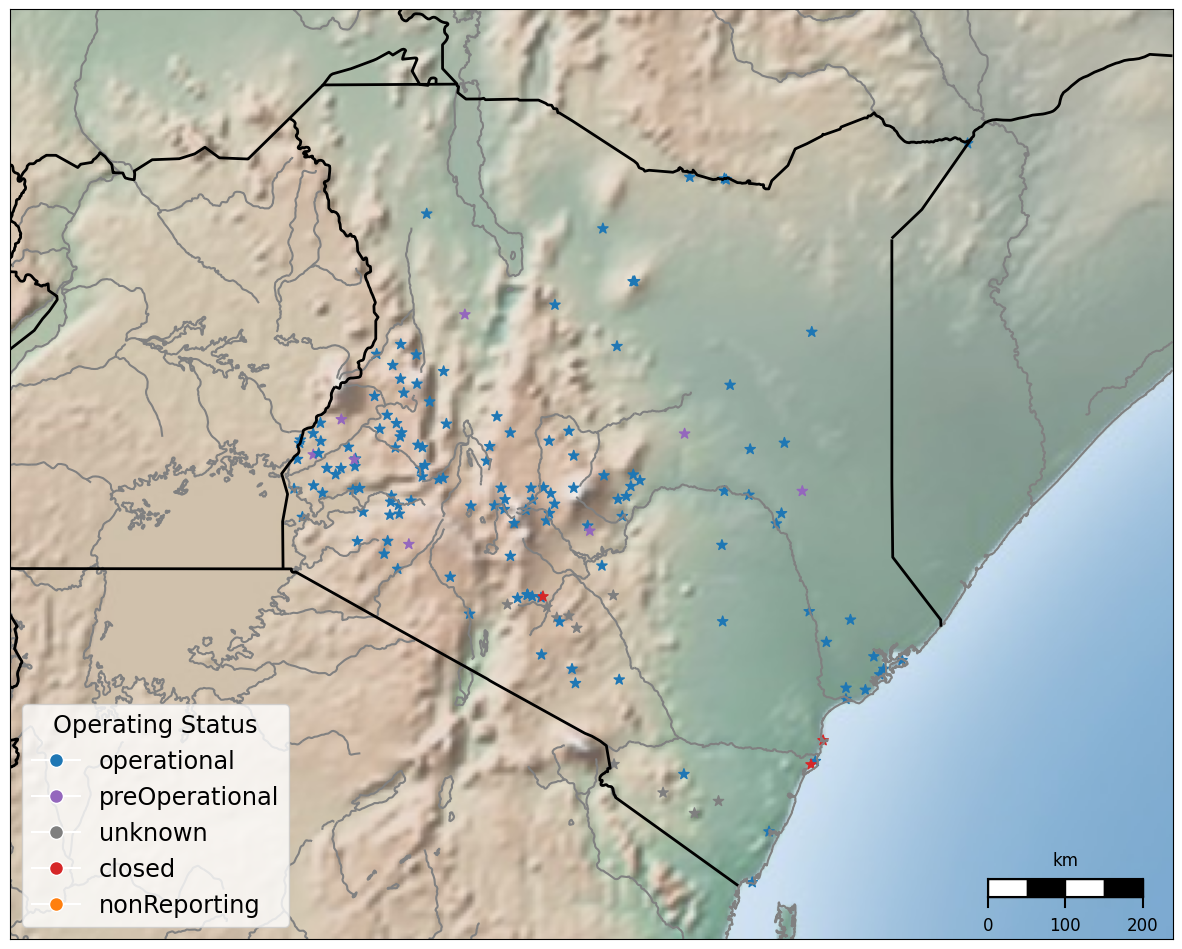

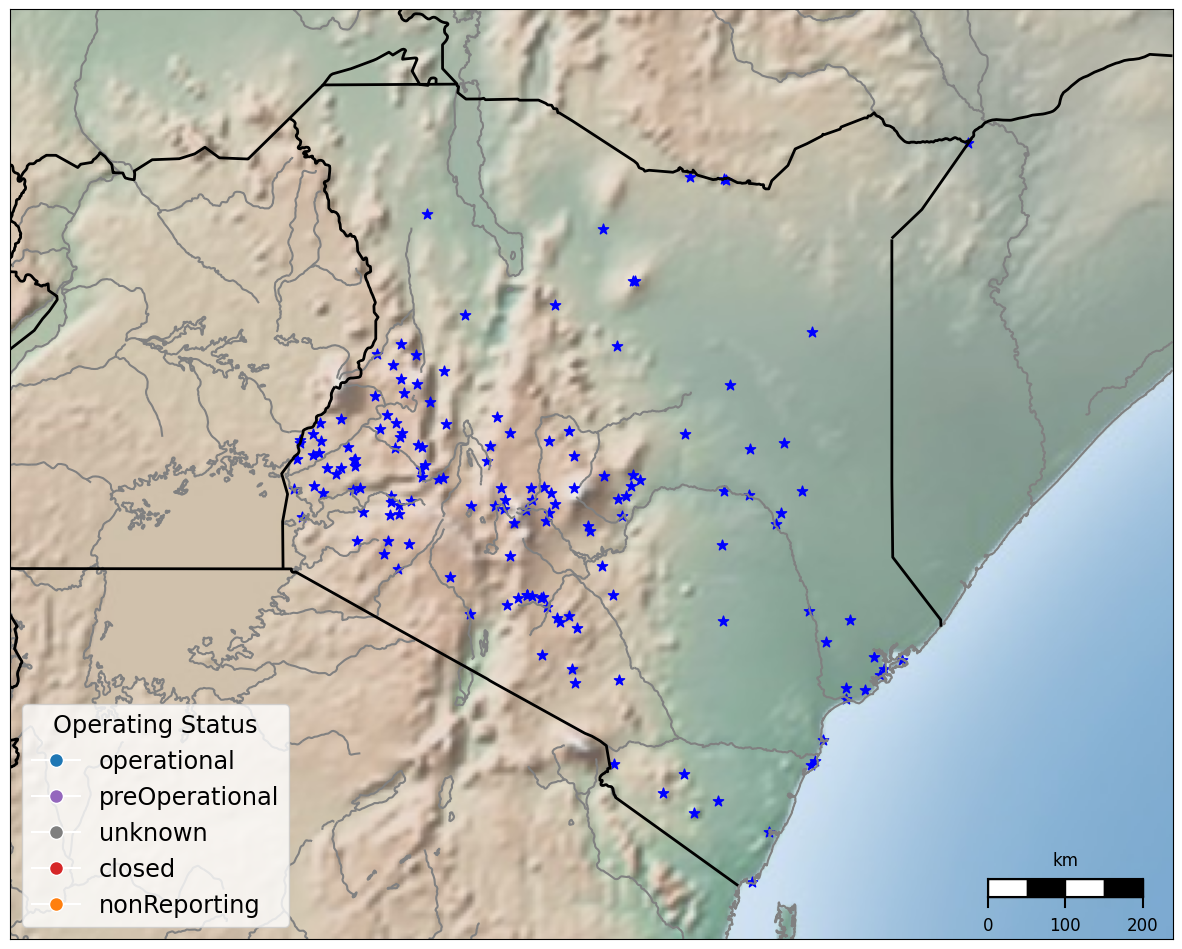

In [116]:
json_file = os.getcwd()+'/stations.json'
plot_overview_map(json_file=json_file, reporting=True)
plot_overview_map(json_file=json_file, reporting=False)

In [100]:
# define function: create plot showing maps (one for every decade) with all catalogued stations within that decade (color of dots according to reporting status)

def plot_maps_establishment_decade(json_file, reporting = True):

    """ reate plot showing maps (one for every decade) with all catalogued stations within that decade 

        Parameters:
        json_file (.json file): containing the required information on the stations 
        (WIGOS ID, name, lat, lon, elevation, facilityType, observed Properties, dateEstablsihed, 
        dateClosed & reportingStatus)
        reporting (boolean): True -> color of dots according to reporting status, False -> all dots the same color
    """  

    # create plot
    plt.style.use('default')
    fig, axes = plt.subplots(2,4, figsize=(16,9.7))
    axes = axes.ravel()

    # load data
    f = open(json_file)
    data = json.load(f) 

    # years
    years = [1961, 1961, 1971, 1981, 1991, 2001, 2011, 2021, 2031]

    # loop over decades; for every decade one map showing the stations established within
    for i, decade in enumerate(["before 1961", "1961 - 1970", "1971 - 1980", "1981 - 1990", "1991 - 2000", "2001 - 2010", "2011 - 2020", "since 2021"]):
            
        # map background
        m = Basemap(projection='lcc', resolution='l', lat_0=0.1, lon_0=37.5, width=1.5E6, height=1.2E6,  ax = axes[i]) 
        m.drawcoastlines(color='grey', linewidth=0.8)
        m.drawcountries(color='black', linewidth=2)

        # find stations established within decade  
        df = pd.DataFrame(data["stations"])  
        if i == 0:
            df = df[(pd.to_datetime(df["dateEstablished"]) < pd.to_datetime(datetime.datetime(1961, 1,1)))]
        else:
            df = df[(pd.to_datetime(df["dateEstablished"]) >= pd.to_datetime(datetime.datetime(years[i], 1,1))) & (pd.to_datetime(df["dateEstablished"]) < pd.to_datetime(datetime.datetime(years[i+1], 1,1)))]

        # plot dots for established stations
        if not df.empty:
            lat = df["lat"]
            lon = df["lon"]
            if reporting == True:
                colors = {'operational':'tab:blue', 'preOperational':'tab:purple', 'unknown':'tab:grey', 'closed':'tab:red', 'nonReporting':'tab:orange'}
                m.scatter(lon, lat, latlon=True, c=df["reportingStatus"].map(colors),s=60,marker="*")
            else:
                m.scatter(lon, lat, latlon=True, c="blue",s=30,marker="*")

        # small title over every map
        axes[i].set_title(decade)

    # large title
    plt.suptitle('Establishment of stations', fontsize=20, fontweight="bold")

    # handles, labels = axes.get_legend_handles_labels()
    if reporting == True:
        stations = [mlines.Line2D([0], [0], color="w", marker='*',markersize=20,  markerfacecolor=v, label=k) for k, v in colors.items()]
        fig.legend(handles=stations, loc='lower center', ncol=len(stations), title="Today's reporting status", title_fontproperties={'weight':'bold'}) 
    plt.tight_layout(pad=1)

    # save plot to folder with today's date
    date_today = date.today()
    date_today.strftime("%m_%d_%Y")

    # check if directory exists, otherwise create
    dir = os.getcwd()+"/Plots/"+str(date_today)
    if not os.path.exists(dir):
        os.makedirs(dir)

    # save plot
    if reporting == True:
        plt.savefig(dir+"/Map_establishment_decade_reporting_"+str(date_today)+"_.jpeg", bbox_inches='tight')
    else: 
        plt.savefig(dir+"/Map_all_stations_reportingStatus_"+str(date_today)+"_.jpeg", bbox_inches='tight')


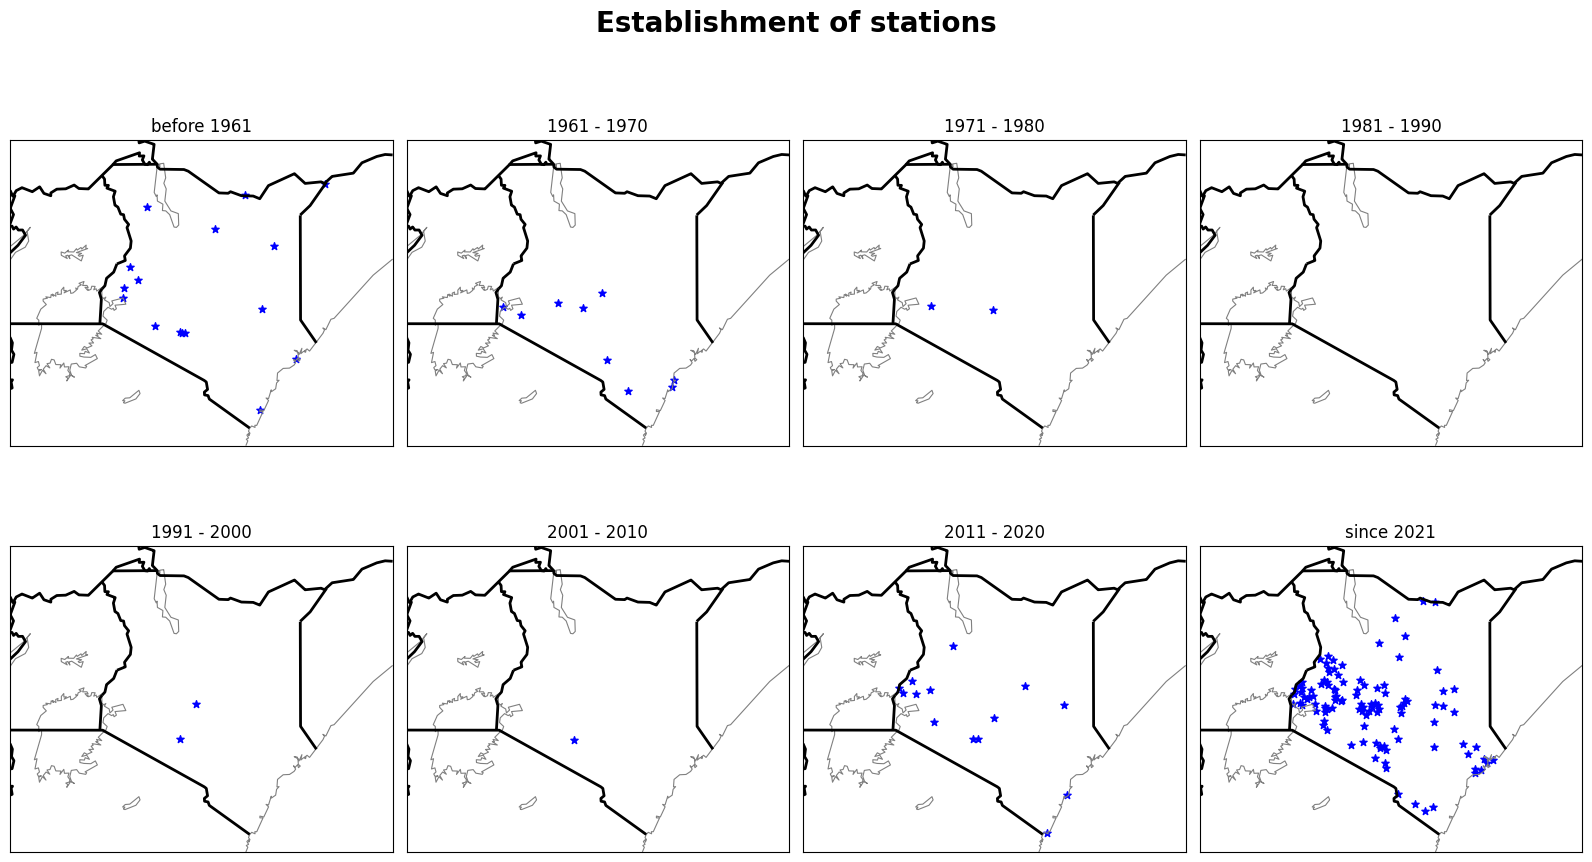

In [102]:
plot_maps_establishment_decade(json_file, reporting=True)
plot_maps_establishment_decade(json_file, reporting=False)

In [109]:
# define function: Animation of stations establishment

def animation_establishment(json_file, background = True):

    """ Animation of station establishment

        Parameters:
        json_file (.json file): containing the required information on the stations 
        (WIGOS ID, name, lat, lon, elevation, facilityType, observed Properties, dateEstablsihed, 
        dateClosed & reportingStatus)

        background (boolean): True (default) -> relief as background, False -> white background
    """   

    # load data
    f = open(json_file)
    data = json.load(f)
    df_animation = pd.DataFrame(data["stations"]) 

    # for legend
    def legend_without_duplicate_labels(figure):
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        figure.legend(by_label.values(), by_label.keys(), loc='lower right')

    # figure
    plt.style.use('default')
    fig = plt.figure()

    # Load map background
    m = Basemap(projection='lcc', resolution='h', lat_0=0.1, lon_0=37.5, width=1.5E6, height=1.2E6)
    if background == True:
        m.shadedrelief()
    m.drawcountries(color='black', linewidth=2)
    m.drawcoastlines(color='grey', linewidth=0.8)
    # m.drawrivers(color='grey', linewidth=1.5)

    point = m.plot([], [], c="blue", marker="*")[0]
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)

    # define animation
    def animate(year):
        df = df_animation[(pd.DatetimeIndex(df_animation["dateEstablished"]).year == year)]
        m.scatter(df["lon"], df["lat"], latlon=True, c="blue",s=30,marker="*", label = "established")

        # station closed:
        for i in range(0,len(df["dateClosed"])):
            if not df.iloc[i]["dateClosed"] == "NA":
                m.scatter(df.iloc[i]["lon"], df.iloc[i]["lat"], latlon=True, c="red",s=30,marker="*", label = "closed")

        # legend & year        
        legend_without_duplicate_labels(plt)
        plt.text(0.1, 0.1, year, color='black', size=17, weight=800, bbox=props,  horizontalalignment='left', verticalalignment='bottom')
        return m,

    # create animation
    ani = animation.FuncAnimation(fig, animate, frames=range(1908,2023), interval=10)

    # To save the animation using Pillow as a gif
    plt.tight_layout()
    writer = animation.PillowWriter(fps=5, bitrate=1800)

    # save plot to folder with today's date
    date_today = date.today()
    date_today.strftime("%m_%d_%Y")

    # check if directory exists, otherwise create
    dir = os.getcwd()+"/Plots/"+str(date_today)
    if not os.path.exists(dir):
        os.makedirs(dir)
    if background == True:
        ani.save(dir+"/Animation_station_establishment_Kenya_"+str(date_today)+"_relief.gif", writer=writer)
    else:
        ani.save(dir+"/Animation_station_establishment_Kenya_"+str(date_today)+"_.gif", writer=writer)

    plt.show()

/home/sdanioth/.local/lib/python3.10/site-packages/pyproj/transformer.py:812: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(


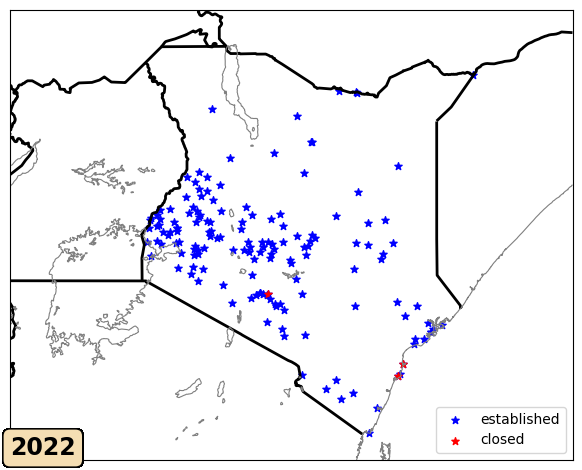

In [110]:
animation_establishment(json_file, background = True)
animation_establishment(json_file, background = False)

In [120]:
# define function: Barplot over the decades showing the station establishment & today's reporting status

def barplot_establishment_decade(json_file, reporting = True):

    """ Barplot showing the number of stations established within a decade (and how many of them are operational today)

        Parameters:
        json_file (.json file): containing the required information on the stations 
        (WIGOS ID, name, lat, lon, elevation, facilityType, observed Properties, dateEstablsihed, 
        dateClosed & reportingStatus)
        reporting (boolean): True -> how many stations are operational today, False -> without today's reporting status
    """  

    # load data
    f = open(json_file)
    data = json.load(f) 

    # prepare
    stations_n = []
    stations_operational = []

    # years
    years = [1961, 1961, 1971, 1981, 1991, 2001, 2011, 2021, 2031]
    decades = ["before 1961", "1961 - 1970", "1971 - 1980", "1981 - 1990", "1991 - 2000", "2001 - 2010", "2011 - 2020", "since 2021"]

    for i, decade in enumerate(decades):

        df = pd.DataFrame(data["stations"])

        if i == 0:
            df = df[(pd.to_datetime(df["dateEstablished"]) < pd.to_datetime(datetime.datetime(years[i], 1,1)))]
            stations_n.append(len(df))
            stations_operational.append(len(df[(df["reportingStatus"]=="operational")]))
        else:
            df = df[(pd.to_datetime(df["dateEstablished"]) >= pd.to_datetime(datetime.datetime(years[i], 1,1))) & (pd.to_datetime(df["dateEstablished"]) < pd.to_datetime(datetime.datetime(years[i+1], 1,1)))]
            stations_n.append(len(df))
            stations_operational.append(len(df[(df["reportingStatus"]=="operational")]))

    plt.style.use('default')
    fig, axes = plt.subplots(1,1, figsize=(8,5))

    n = len(decades)
    r = np.arange(n) 
    width = 0.4
    if reporting == True:
        plt.bar(r, stations_n, width=width, label= "total", color="purple")
        plt.bar(r + width, stations_operational, width=width, label="currently operational", color="blue")
    else:
        plt.bar(decades, stations_n, width=0.4)

    # labels, legend, title
    plt.xlabel("Period", fontsize=12, fontweight="bold")
    plt.xticks(r + width/2,decades, rotation=25) 
    plt.ylabel("Number of stations established", fontsize=12, fontweight="bold")
    plt.title("Establishment of stations", fontsize=16, fontweight="bold")
    plt.legend() 

    # save plot to folder with today's date
    date_today = date.today()
    date_today.strftime("%m_%d_%Y")

    # check if directory exists, otherwise create
    dir = os.getcwd()+"/Plots/"+str(date_today)
    if not os.path.exists(dir):
        os.makedirs(dir)

    # save plot
    if reporting == True:
        plt.savefig(dir+"/Barplot_station_establishment_"+str(date_today)+"_reporting.jpeg", bbox_inches='tight')
    else: 
        plt.savefig(dir+"/Barplot_station_establishment_"+str(date_today)+"_.jpeg", bbox_inches='tight')
            

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


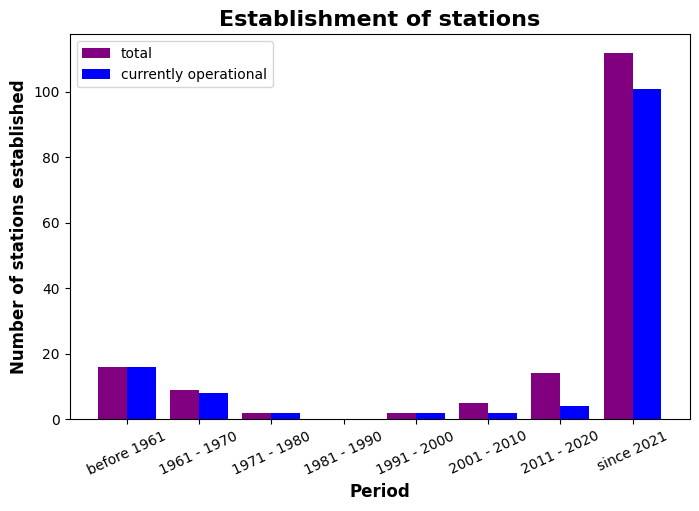

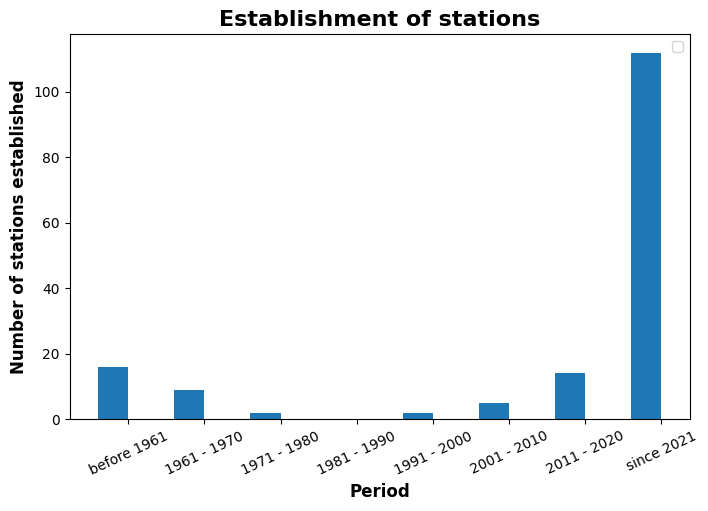

In [122]:
barplot_establishment_decade(json_file=json_file, reporting=True)
barplot_establishment_decade(json_file=json_file, reporting=False)

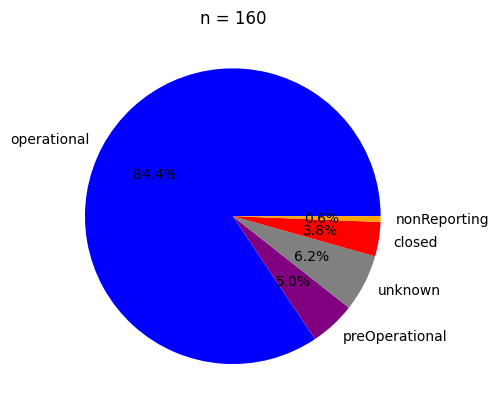

In [23]:
#### Pie chart: today's reporting status ####

df = pd.DataFrame(data["stations"])

status = ['operational', 'preOperational', 'unknown', 'closed', 'nonReporting']
status_n = []

for stat in status:
    status_n.append(len(df[df["reportingStatus"]==stat]))

colors = ['blue', 'purple', 'grey', 'red', 'orange']

fig, ax = plt.subplots()
ax.pie(status_n, labels=status, colors=colors,  autopct='%1.1f%%')
plt.title("n = " + str(len(df)))

plt.savefig(os.getcwd()+"/Plots/Station_ReportingStatus_piechart.jpeg", bbox_inches='tight')


In [24]:
# find all variables measured at a station in the past (unique)
df = pd.DataFrame(data["stations"])
df["observedProperties_unique"] = range(0,len(df))
pd.options.mode.chained_assignment = None

from functools import reduce
 
def unique(list1):
 
    # Print directly by using * symbol
    ans = reduce(lambda re, x: re+[x] if x not in re else re, list1, [])
    return(ans)

for i in range(0,len(df)):
    unique_codes = unique(df["observedProperties"][i])
    # print(unique_codes)
    df["observedProperties_unique"][i] = unique_codes

# print(df["observedProperties_unique"])

In [25]:
df_count = pd.Series(sum([item for item in df.observedProperties_unique], [])).value_counts()
df_count = pd.DataFrame(df_count)

df_count.index.name = 'variables'
df_count.reset_index(inplace=True)

print(df_count)

   variables  count
0        251    151
1        216    151
2        224    151
3      12005    150
4      12006    150
5        210    142
6        230     35
7        531     28
8        265     28
9        550     28
10       179     27
11       266     27
12       510     23
13       270     23
14       225      6
15        94      5
16       596      5
17        91      5
18        18      5
19       573      4
20       192      3
21       194      3
22       264      2
23       227      2
24       310      2
25       527      2
26     12000      2
27       256      2
28       445      1
29        37      1
30       325      1
31       263      1
32     12162      1
33       502      1
34       501      1
35       499      1
36       497      1
37       437      1
38       248      1
39       318      1
40       571      1
41       262      1
42       205      1
43       203      1
44       201      1
45       196      1
46       195      1
47       284      1


In [26]:
# combine 3 dictionaries (Atmosphere, Ocean & Terrestrial)

with open(os.getcwd()+"/WMDR_dictionaries/T_GO_VARIABLE_REF_dictionary.json") as f:
    dictionary = json.loads(f.read())

print(dictionary)

{'label': 'notation', 'Crustal motion (horizontal and vertical)': '6', 'Crustal plates positioning': '7', 'Earth Rotation': '8', 'Geoid': '9', 'Geomagnetic field': '10', 'Gravity field': '11', 'Gravity gradients': '12', 'Bathymetry': '13', 'Pressure': '18', 'Aerological soundings': '37', 'Atmospheric density': '39', 'Integrated air samples': '44', 'Special phenomena': '56', 'State of ground': '57', 'Ocean current direction': '62', 'Ocean current speed': '63', 'Ocean dynamic topography (ODT)': '64', 'Surface currents': '65', 'Dissolved inorganic carbon (DIC)': '67', 'Dissolved organic carbon': '68', 'Dissolved organic nitrogen': '69', 'Diffuse attenuation coefficient (DAC), turbidity': '70', 'Chlorophyll a concentration': '71', 'Ocean suspended sediments concentration': '72', 'Oil spill cover': '73', 'Primary production': '74', 'Sea surface mass flux': '75', 'Ocean Surface heat flux': '76', 'Sea surface height anomaly (SSHA)': '77', 'Total alkalinity (TA)': '78', 'pH': '79', 'SiO3= (met

In [27]:
#### find variable names instead of notations

# df = pd.DataFrame(data["stations"])

variables = df_count["variables"]
# print(variables)
print(type(df_count["variables"]))

df_count["variables_names"] = [(list(dictionary.keys())[list(dictionary.values()).index(var)]) for var in variables]
print(df_count)

<class 'pandas.core.series.Series'>
   variables  count                                    variables_names
0        251    151  Humidity  (at specified distance from referenc...
1        216    151                               Atmospheric pressure
2        224    151  Air temperature (at specified distance from re...
3      12005    150  Horizontal wind direction at specified distanc...
4      12006    150  Horizontal wind speed at specified distance fr...
5        210    142                            Amount of precipitation
6        230     35                                         Visibility
7        531     28                               Height of cloud base
8        265     28                                       Past weather
9        550     28                                      Type of cloud
10       179     27                                       Cloud amount
11       266     27                                    Present weather
12       510     23                      

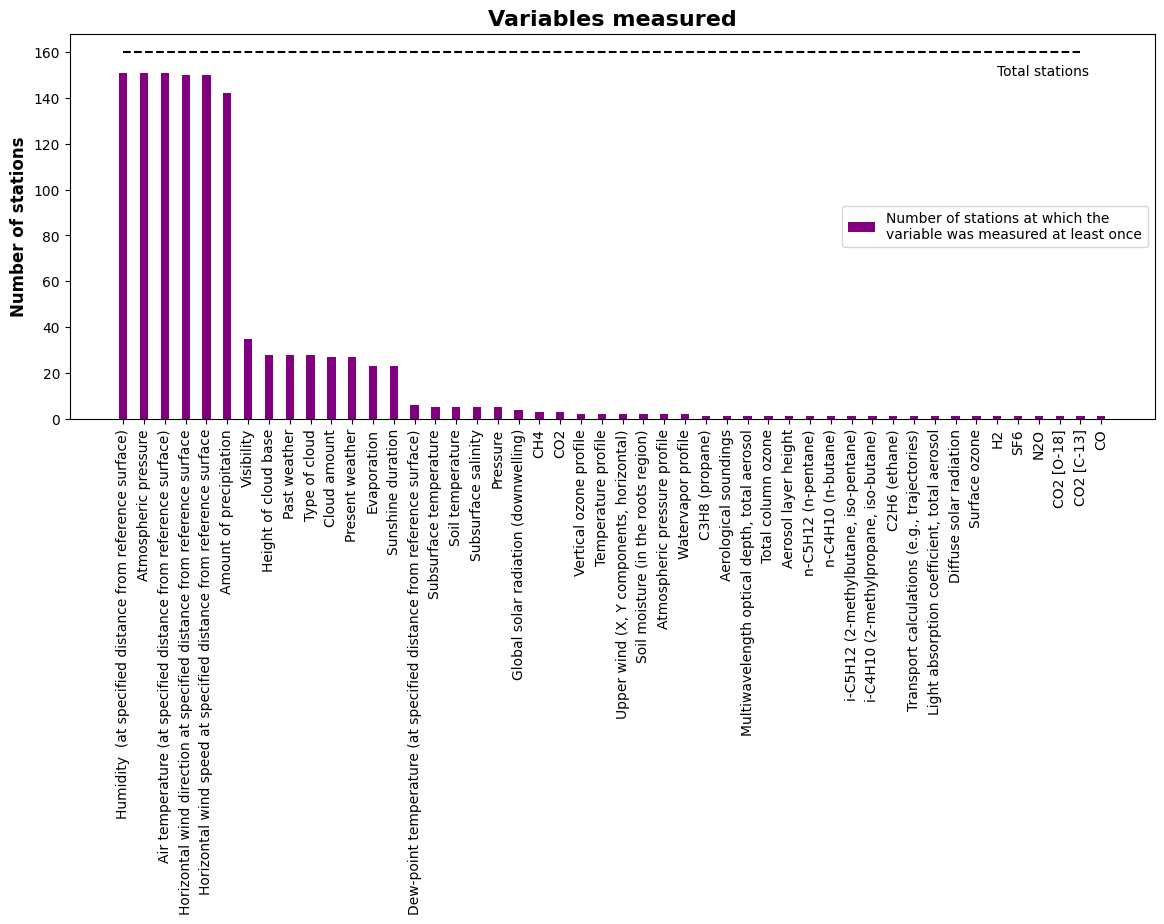

In [29]:
plt.style.use('default')
fig, axes = plt.subplots(1,1, figsize=(14,5))

plt.bar(df_count["variables_names"], df_count["count"], width=0.4, color="purple", label="Number of stations at which the\nvariable was measured at least once")
plt.hlines(y = len(df), xmin=0, xmax=46, colors="k", ls="--")
t = plt.text(42, 150, "Total stations", fontsize=10)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
plt.xticks(rotation=90)
plt.legend(loc="center right", fontsize=10, scatterpoints=10)
# plt.xlabel("Variables", fontsize=12, fontweight="bold")
plt.ylabel("Number of stations", fontsize=12, fontweight="bold")
plt.title("Variables measured", fontsize=16, fontweight="bold")

plt.savefig(os.getcwd()+"/Plots/MeasuredVariables_Overview.jpeg", bbox_inches='tight')
